<h1><center><font size="6">Jigsaw EDA</font></center></h1>

<center><img src="https://upload.wikimedia.org/wikipedia/commons/7/75/Jigsaw.svg" width="300"></img></center>

<br>

# <a id='0'>Content</a>

- <a href='#1'>Introduction</a>  
- <a href='#2'>Prepare the data analysis</a>  
- <a href='#3'>Data exploration</a>   
    - <a href='#31'>Target feature</a>   
    - <a href='#32'>Sensitive topics features</a>   
    - <a href='#33'>Feedback information</a>   
    - <a href='#34'>Comments data wordclouds</a>   
    - <a href='#35'>Comments data topic modelling</a>  
    - <a href='#36'>Comments name entity recognition (NER)</a>  
    - <a href='#37'>Comments part of speech tagging</a>  
- <a href='#4'>Prepare the model</a>    
    - <a href='#41'>Build vocabulary</a>   
    - <a href='#42'>Embedding index and embedding matrix</a>   
    - <a href='#43'>Check coverage</a>   
    - <a href='#44'>Transform to lowercase</a>   
    - <a href='#45'>Remove contractions</a>   
    - <a href='#46'>Remove punctuation</a>  
    - <a href='#47'>Tokenize</a>  
- <a href='#5'>Conclusions</a>      
- <a href='#6'>References</a>   

# <a id='1'>Introduction</a>  

## Competition objective

The competition objective is to build models that detect toxicity and reduce unwanted bias. 
For example, if a certain minority name is frequently associated with toxic comments, some models might associate the presence of the minority name in a message that is not toxic wiht toxicity and wrongly classify the comment as toxic.

## Background

At the end of 2017 the Civil Comments platform shut down and chose make their ~2m public comments from their platform available in a lasting open archive so that researchers could understand and improve civility in online conversations for years to come. Jigsaw sponsored this effort and extended annotation of this data by human raters for various toxic conversational attributes.

## References

Please consult the <a href='#5'>References</a> section for the datasets, Kernels and articles used in this Kernel. Special mention for tje Kernels of @anebzt [8] and @christofhenkel [9].


---

<div style="float: right;">
        <a href="#0" class="button btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="Go to Top">Go to Top</a>
</div>

# <a id='2'>Prepare the data analysis</a>  

## Load packages

In [1]:
import gc
import os
import warnings
warnings.filterwarnings('ignore')
import operator
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook, tqdm
from wordcloud import WordCloud, STOPWORDS
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
import spacy
from spacy import displacy
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import nltk
from nltk.tokenize import TreebankWordTokenizer as twt
from gensim import corpora, models
import pyLDAvis
import pyLDAvis.gensim
from keras.preprocessing.text import Tokenizer

pyLDAvis.enable_notebook()
np.random.seed(2018)


In [2]:
from plot_style_utils import plot_count, show_wordcloud, set_color_map

## Load data

In [3]:
%%time
JIGSAW_PATH = "../input/jigsaw-unintended-bias-in-toxicity-classification/"
train = pd.read_csv(os.path.join(JIGSAW_PATH,'train.csv'), index_col='id')
test = pd.read_csv(os.path.join(JIGSAW_PATH,'test.csv'), index_col='id')

CPU times: user 15.6 s, sys: 2.47 s, total: 18 s
Wall time: 25.2 s


In [4]:
train.head()

target                                       comment_text  \
id                                                                   
59848  0.000000  This is so cool. It's like, 'would you want yo...   
59849  0.000000  Thank you!! This would make my life a lot less...   
59852  0.000000  This is such an urgent design problem; kudos t...   
59855  0.000000  Is this something I'll be able to install on m...   
59856  0.893617               haha you guys are a bunch of losers.   

       severe_toxicity  obscene  identity_attack   insult  threat  asian  \
id                                                                         
59848         0.000000      0.0         0.000000  0.00000     0.0    NaN   
59849         0.000000      0.0         0.000000  0.00000     0.0    NaN   
59852         0.000000      0.0         0.000000  0.00000     0.0    NaN   
59855         0.000000      0.0         0.000000  0.00000     0.0    NaN   
59856         0.021277      0.0         0.021277  0.87234     0.0    0.0   

       atheist  bisexual  ...  article_id    rating  funny  wow  sad  likes  \
id                        ...                                                 
59848      NaN       NaN  ...        2006  rejected      0    0    0      0   
59849      NaN       NaN  ...        2006  rejected      0    0    0      0   
59852      NaN       NaN  ...        2006  rejected      0    0    0      0   
59855      NaN       NaN  ...        2006  rejected      0    0    0      0   
59856      0.0       0.0  ...        2006  rejected      0    0    0      1   

       disagree  sexual_explicit  identity_annotator_count  \
id                                                           
59848         0              0.0                         0   
59849         0              0.0                         0   
59852         0              0.0                         0   
59855         0              0.0                         0   
59856         0              0.0                         4   

       toxicity_annotator_count  
id                               
59848                         4  
59849                         4  
59852                         4  
59855                         4  
59856                        47  

[5 rows x 44 columns]

In [5]:
test.head()

comment_text
id                                                        
7097320  [ Integrity means that you pay your debts.]\n\...
7097321  This is malfeasance by the Administrator and t...
7097322  @Rmiller101 - Spoken like a true elitist. But ...
7097323  Paul: Thank you for your kind words.  I do, in...
7097324  Sorry you missed high school. Eisenhower sent ...

In [6]:
print("Train and test shape: {} {}".format(train.shape, test.shape))

Train and test shape: (1804874, 44) (97320, 1)


---

<div style="float: right;">
        <a href="#0" class="button btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="Go to Top">Go to Top</a>
</div>

# <a id='3'>Data exploration</a>  

The comments are stored in `train` and `test` in `comment_text` column.  
Additionally, in `train` we have flags for the presence in the comments of a certain sensitive topic.
The topic is related to five categories: race or ethnicity, gender, sexual orientation, religion, disability, as following:
* **race or ethnicity**: asian, black, jewish, latino, other_race_or_ethnicity, white  
* **gender**: female, male, transgender, other_gender  
* **sexual orientation**: bisexual, heterosexual, homosexual_gay_or_lesbian, other_sexual_orientation  
* **religion**: atheist,buddhist,  christian, hindu, muslim, other_religion  
* **disability**: intellectual_or_learning_disability, other_disability, physical_disability, psychiatric_or_mental_illness  

We also have few article/comment identification information:
* created_date  
* publication_id   
* parent_id  
* article_id 

Several user feedback information associated with the comments are provided:
* rating  
* funny  
* wow  
* sad  
* likes  
* disagree  
* sexual_explicit  

In the datasets are also 2 fields relative to annotations:
* identity_annotator_count  
* toxicity_annotator_count




##  <a id='31'>Target feature</a>

Let's check the distribution of `target` value in the train set.

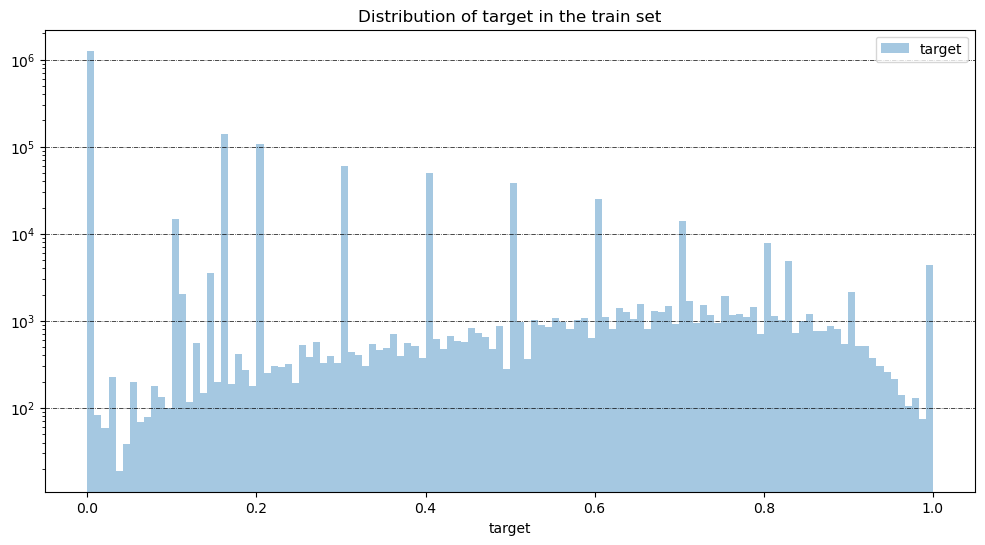

In [7]:
plt.figure(figsize=(12,6))
plt.title("Distribution of target in the train set")
sns.distplot(train['target'],kde=False,hist=True, bins=120, label='target')
plt.grid(color="black", linestyle="-.", linewidth=0.5, axis="y", which="major")
plt.legend(); plt.yscale(value="log"); plt.show()

And let's represent similarly the distribution of the additional toxicity features.

In [8]:
def plot_features_distribution(features, title):
    plt.figure(figsize=(12,6))
    plt.title(title)
    for feature in features:
        sns.distplot(train.loc[~train[feature].isnull(),feature],kde=False,hist=True, bins=120, label=feature)
    plt.grid(color="black", linestyle="-.", linewidth=0.5, axis="y", which="major")
    plt.xlabel('')
    plt.yscale(value="log")
    plt.legend()
    plt.show()

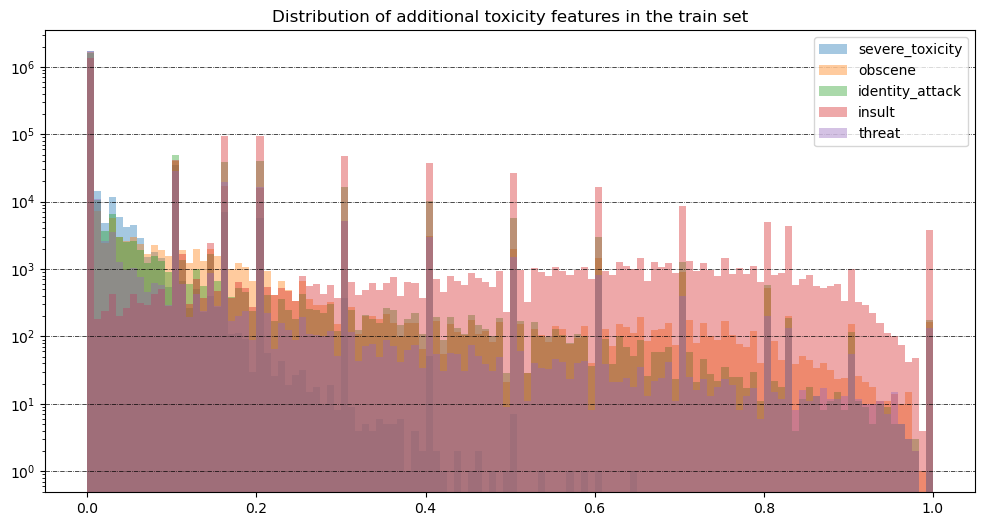

In [9]:
features = ['severe_toxicity', 'obscene','identity_attack','insult','threat']
plot_features_distribution(features, "Distribution of additional toxicity features in the train set")

---

<div style="float: right;">
        <a href="#0" class="button btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="Go to Top">Go to Top</a>
</div>

## <a id='32'>Sensitive topics features</a>

Let's check now the distribution of sensitive topics features values.

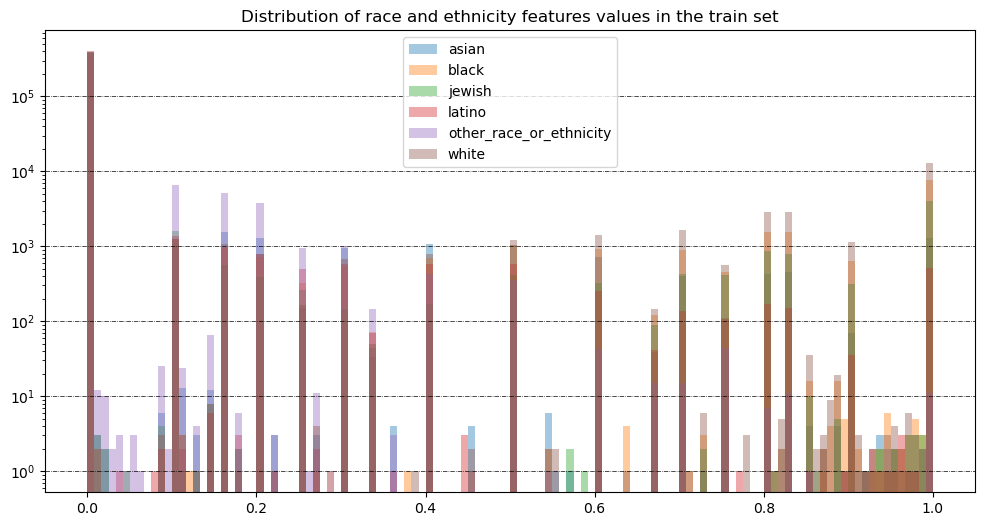

In [10]:
features = ['asian', 'black', 'jewish', 'latino', 'other_race_or_ethnicity', 'white']
plot_features_distribution(features, "Distribution of race and ethnicity features values in the train set")

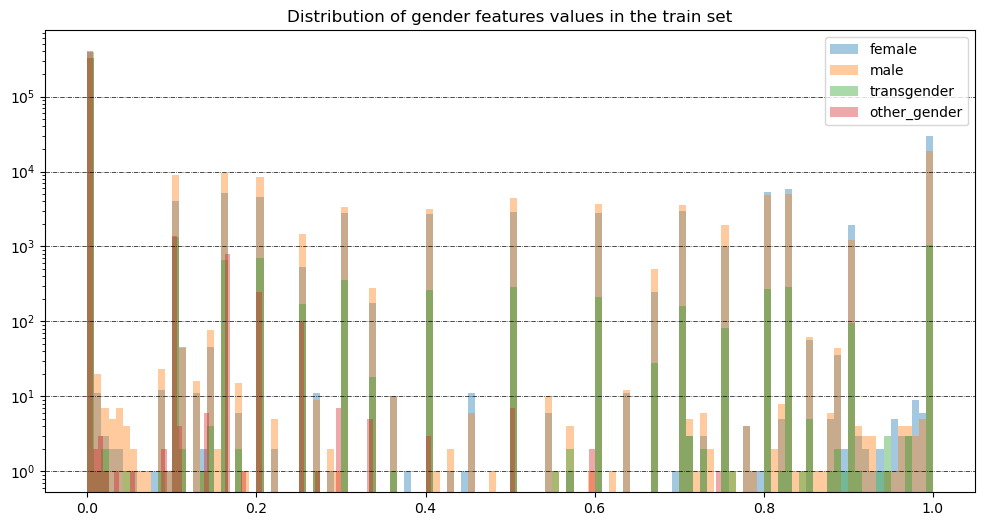

In [11]:
features = ['female', 'male', 'transgender', 'other_gender']
plot_features_distribution(features, "Distribution of gender features values in the train set")

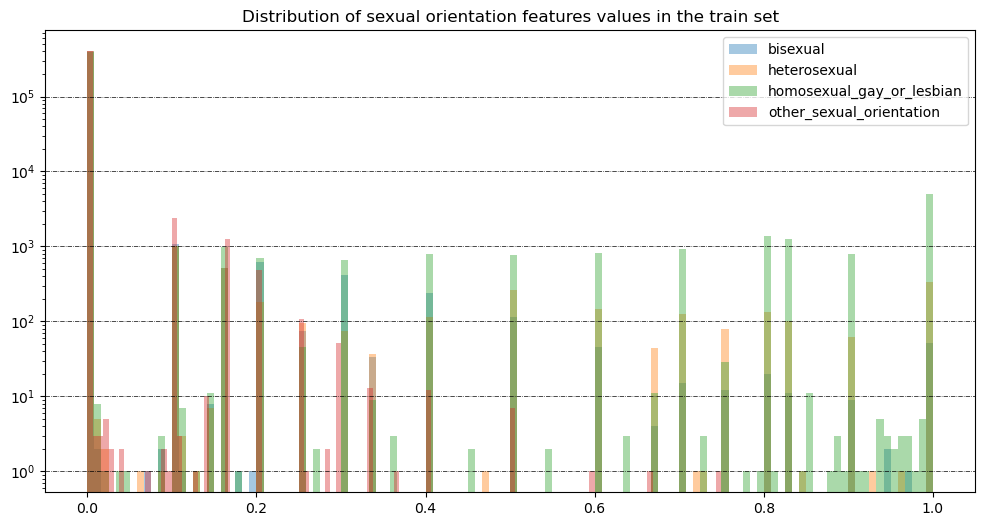

In [12]:
features = ['bisexual', 'heterosexual', 'homosexual_gay_or_lesbian', 'other_sexual_orientation']
plot_features_distribution(features, "Distribution of sexual orientation features values in the train set")

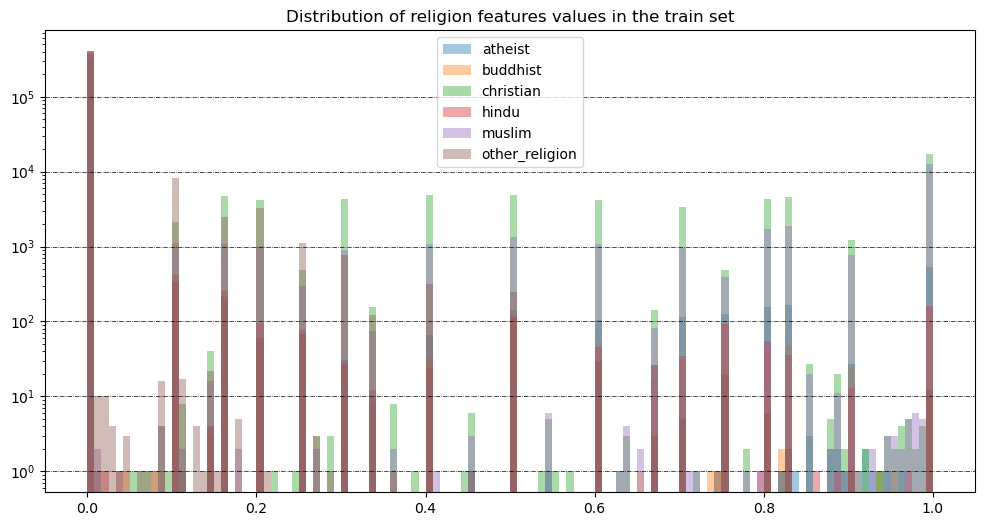

In [13]:
features = ['atheist','buddhist',  'christian', 'hindu', 'muslim', 'other_religion']
plot_features_distribution(features, "Distribution of religion features values in the train set")

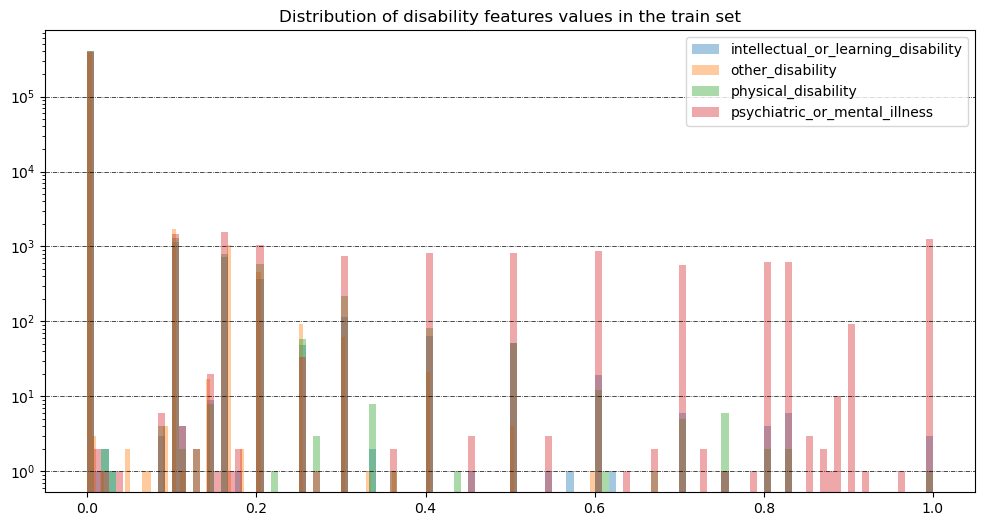

In [14]:
features = ['intellectual_or_learning_disability', 'other_disability', 'physical_disability', 'psychiatric_or_mental_illness']
plot_features_distribution(features, "Distribution of disability features values in the train set")

In [15]:
sel_columns = ['target',  'severe_toxicity', 'obscene',
       'identity_attack', 'insult', 'threat', 'asian', 'atheist', 'bisexual',
       'black', 'buddhist', 'christian', 'female', 'heterosexual', 'hindu',
       'homosexual_gay_or_lesbian', 'intellectual_or_learning_disability',
       'jewish', 'latino', 'male', 'muslim', 'other_disability',
       'other_gender', 'other_race_or_ethnicity', 'other_religion',
       'other_sexual_orientation', 'physical_disability',
       'psychiatric_or_mental_illness', 'transgender', 'white']

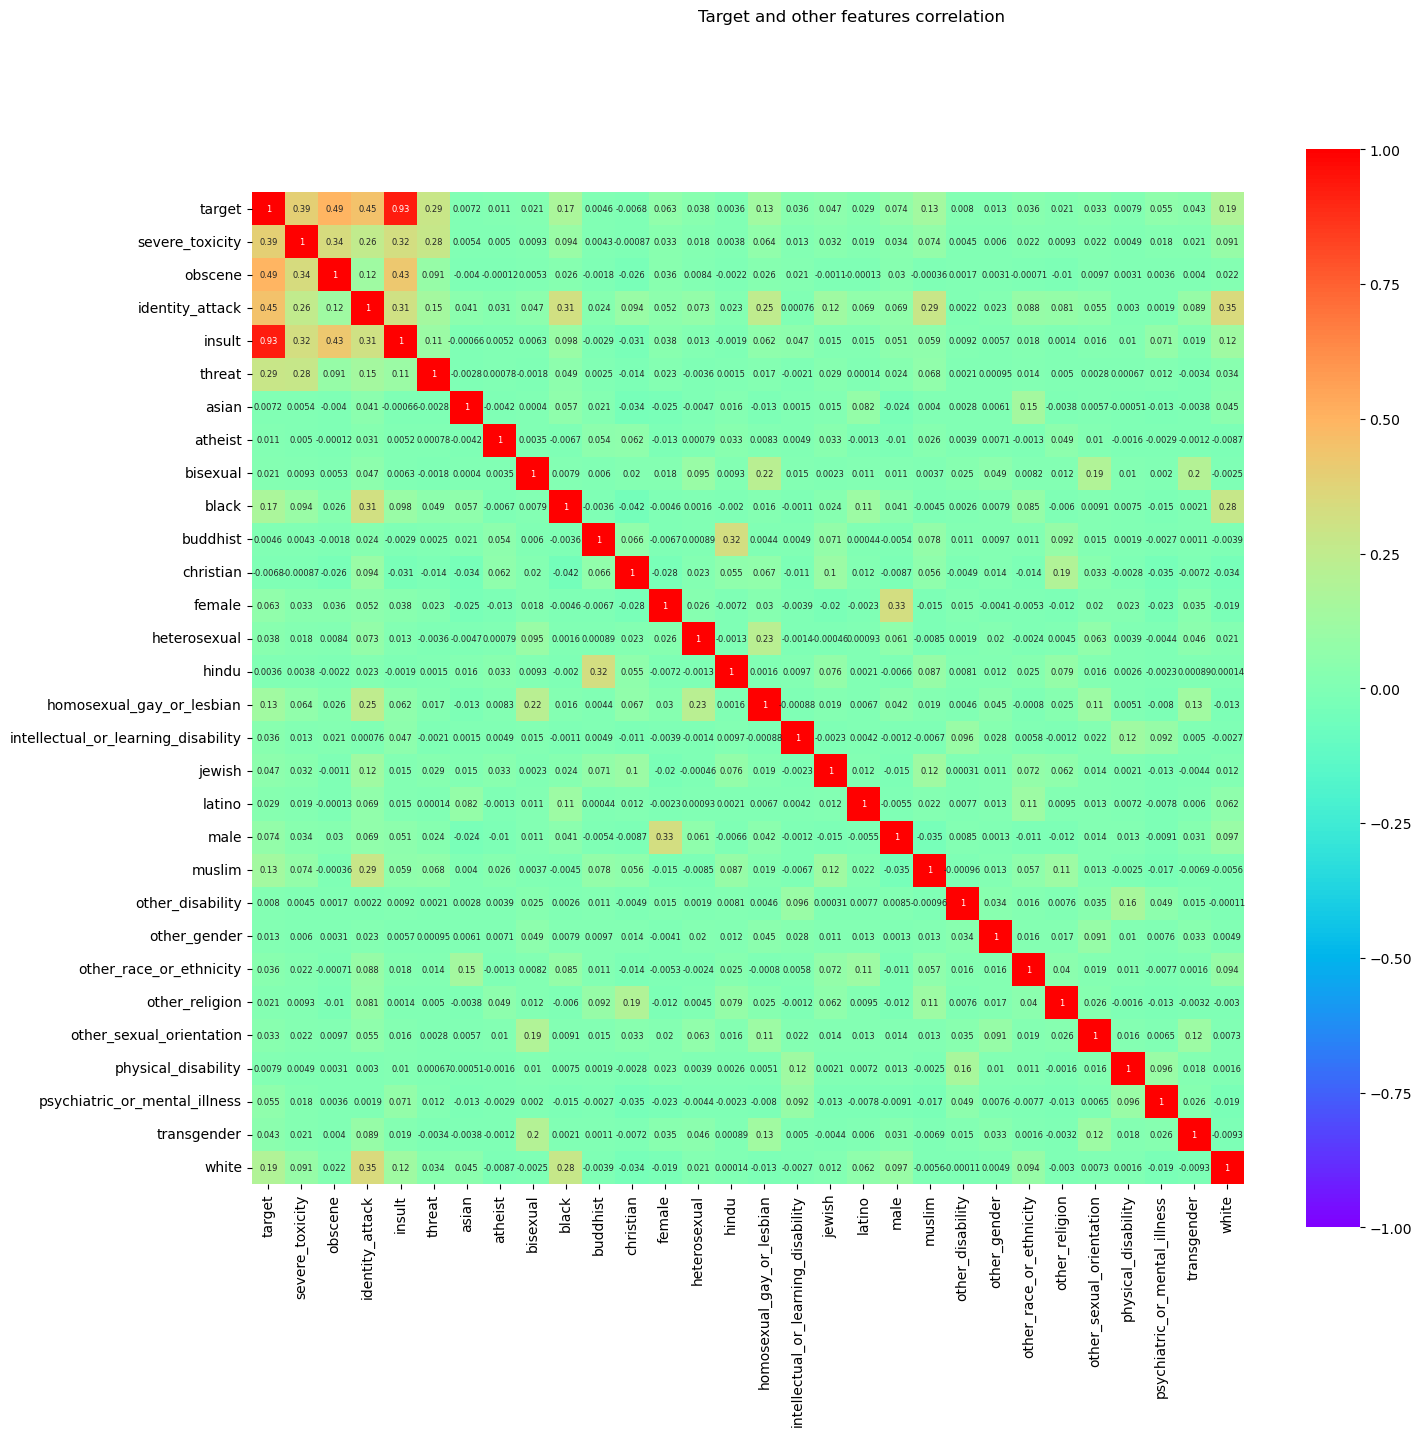

In [16]:
train_corr = train[sel_columns].corr()

fig, ax = plt.subplots(1, 1, figsize = (16, 14))
sns.heatmap(train_corr, 
            xticklabels=train_corr.columns.values,
            yticklabels=train_corr.columns.values, 
            cmap='rainbow', vmin=-1, vmax=1, annot=True, square=True,
            annot_kws={"size":6})
plt.suptitle('Target and other features correlation')
plt.show()

Let's check the top 10 correlation values for all other features with `target` feature.

In [17]:
train_corr['target'].sort_values(ascending=False)[1:16]

insult                           0.928207
obscene                          0.493058
identity_attack                  0.450017
severe_toxicity                  0.393425
threat                           0.287761
white                            0.194012
black                            0.167224
muslim                           0.134491
homosexual_gay_or_lesbian        0.131110
male                             0.073822
female                           0.062904
psychiatric_or_mental_illness    0.055470
jewish                           0.047042
transgender                      0.042517
heterosexual                     0.038193
Name: target, dtype: float64

Let's recreate the correlation matrix for only these fields.

In [18]:
sel_columns = train_corr['target'].sort_values(ascending=False)[0:16].index

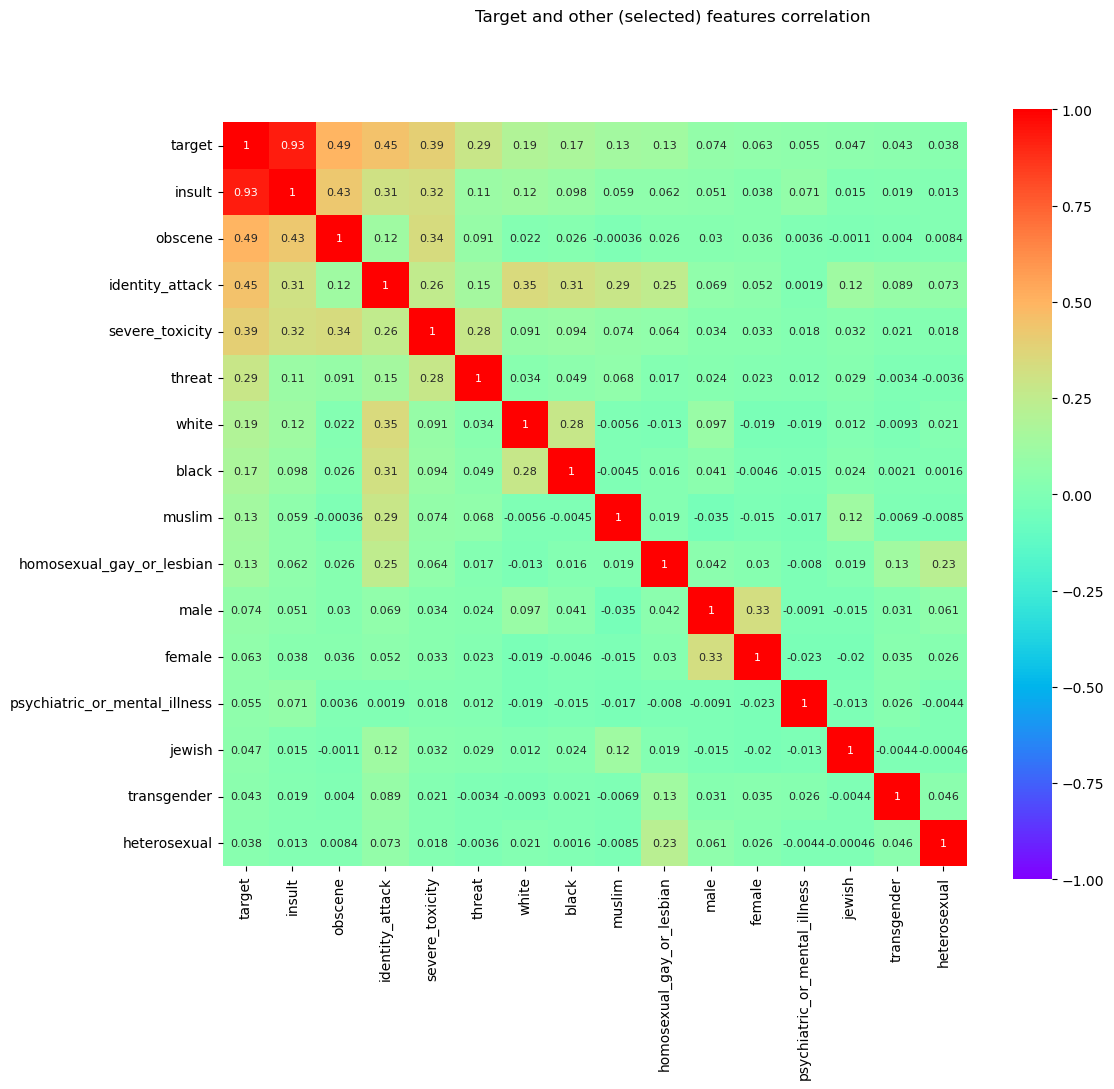

In [19]:
train_corr = train[sel_columns].corr()

fig, ax = plt.subplots(1, 1, figsize = (12, 10))
sns.heatmap(train_corr, 
            xticklabels=train_corr.columns.values,
            yticklabels=train_corr.columns.values, 
            cmap='rainbow', vmin=-1, vmax=1, annot=True, square=True,
            annot_kws={"size":8})
plt.suptitle('Target and other (selected) features correlation')
plt.show()

---

<div style="float: right;">
        <a href="#0" class="button btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="Go to Top">Go to Top</a>
</div>

## <a id='33'>Feedback information</a>

Let's show the feedback values distribution.

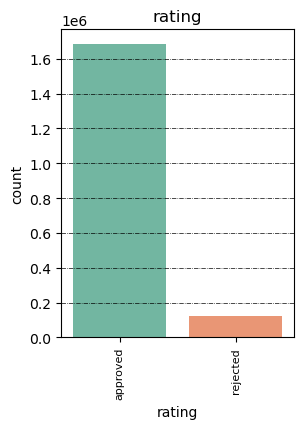

In [20]:
plot_count(train, 'rating','rating', "Set2", size=1)

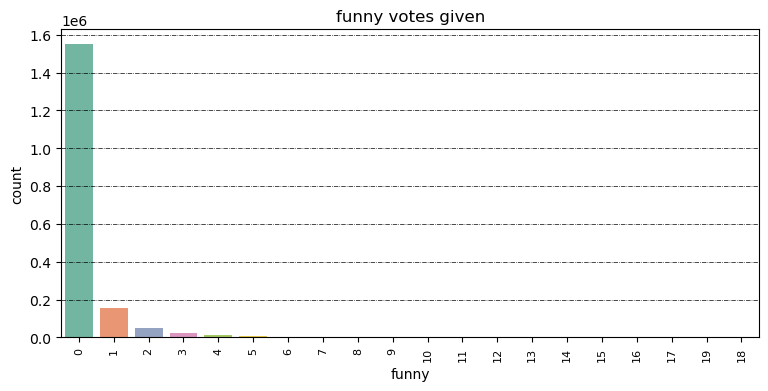

In [21]:
plot_count(train, 'funny','funny votes given','Set2', 3)

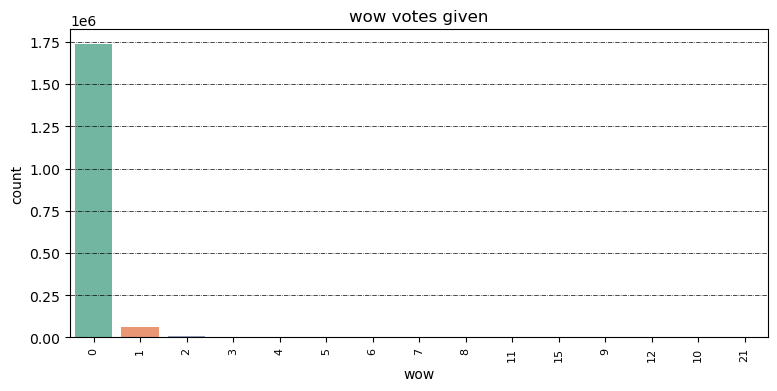

In [22]:
plot_count(train, 'wow','wow votes given','Set2', 3)

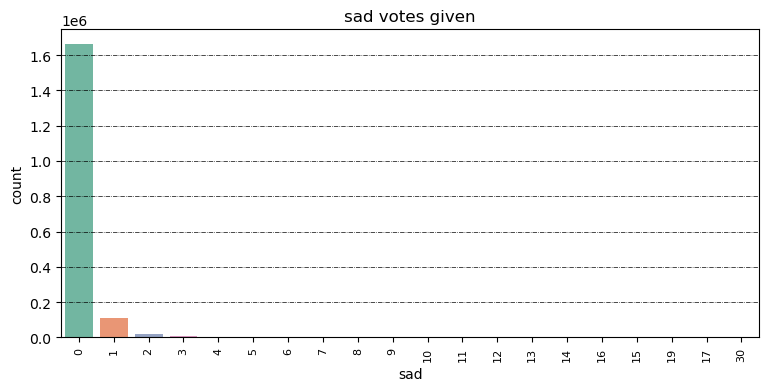

In [23]:
plot_count(train, 'sad','sad votes given','Set2', 3)

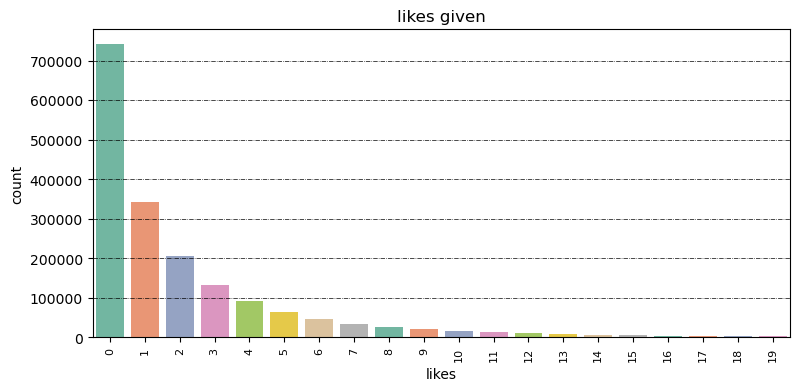

In [24]:
plot_count(train, 'likes','likes given', 'Set2', 3)

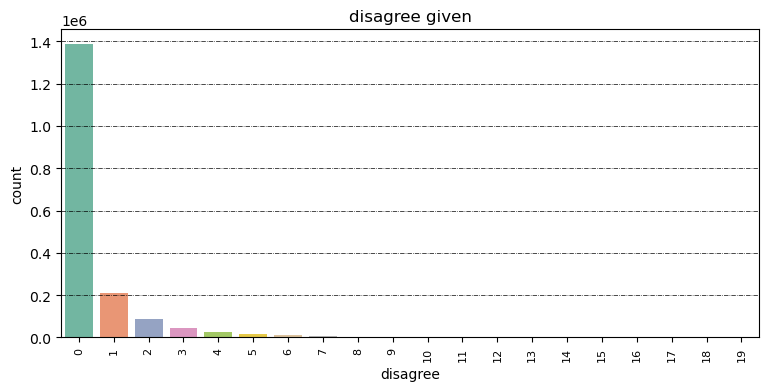

In [25]:
plot_count(train, 'disagree','disagree given', 'Set2', 3)

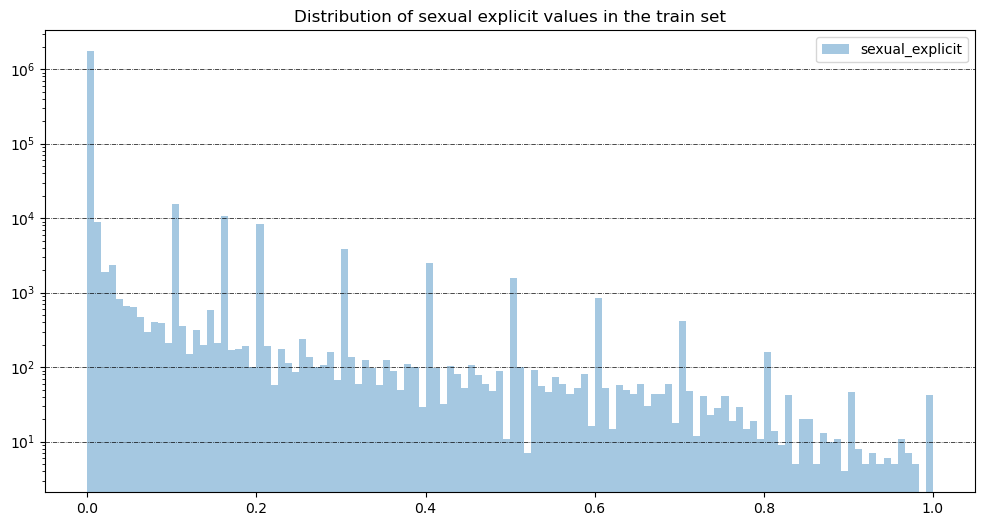

In [26]:
features = ['sexual_explicit']
plot_features_distribution(features, "Distribution of sexual explicit values in the train set")

---

<div style="float: right;">
        <a href="#0" class="button btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="Go to Top">Go to Top</a>
</div>

## <a id='34'>Comments data wordclouds</a>

Let's show the wordcloud of frequent used words in the comments. A maximum of 50 words are shown.

Let's show the prevalent words in the train set (we will use a **20,000** comments sample and show top **50** words).

/opt/conda/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


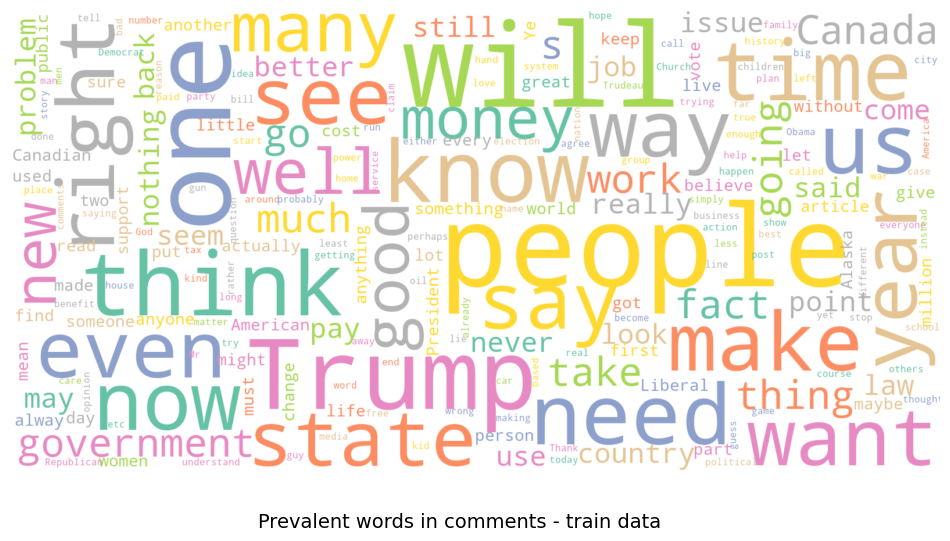

In [27]:
cmap_custom = 'Set2'
show_wordcloud(train['comment_text'].sample(20000), title = 'Prevalent words in comments - train data')

Let's show now the frequent used words in comments for which insult score under **0.25** and above **0.75**.

/opt/conda/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


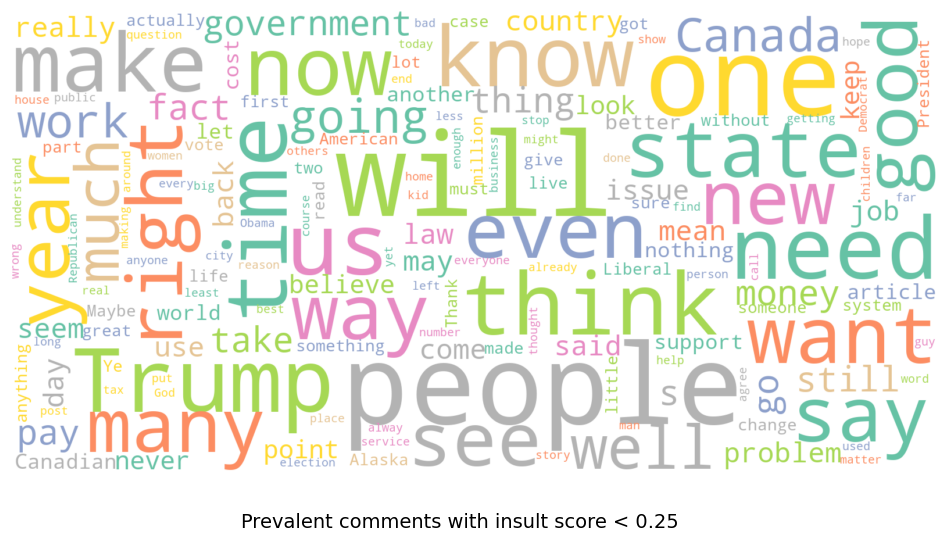

In [28]:
show_wordcloud(train.loc[train['insult'] < 0.25]['comment_text'].sample(20000), 
               title = 'Prevalent comments with insult score < 0.25')

/opt/conda/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


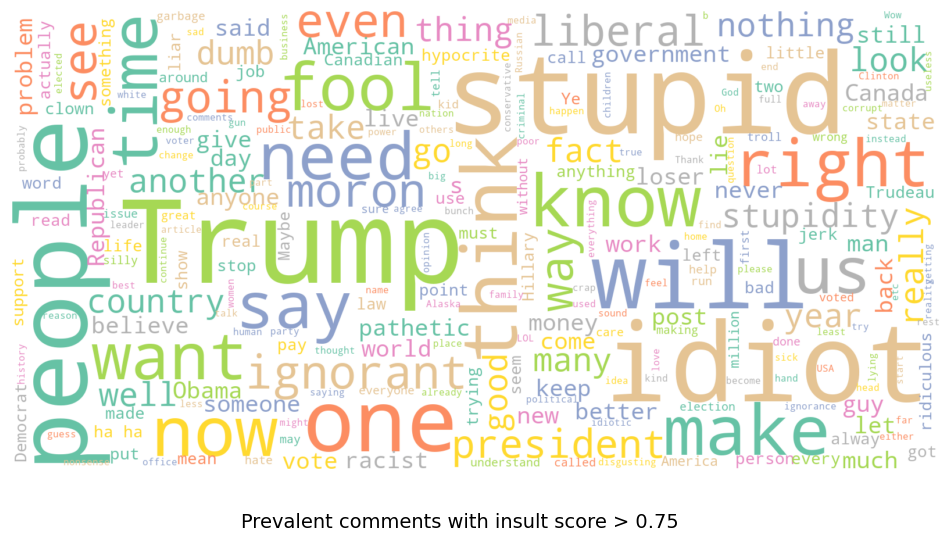

In [29]:
show_wordcloud(train.loc[train['insult'] > 0.75]['comment_text'].sample(20000), 
               title = 'Prevalent comments with insult score > 0.75')

We show now the most frequent words for comments with threat score bellow **0.25** and above **0.75**.

/opt/conda/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


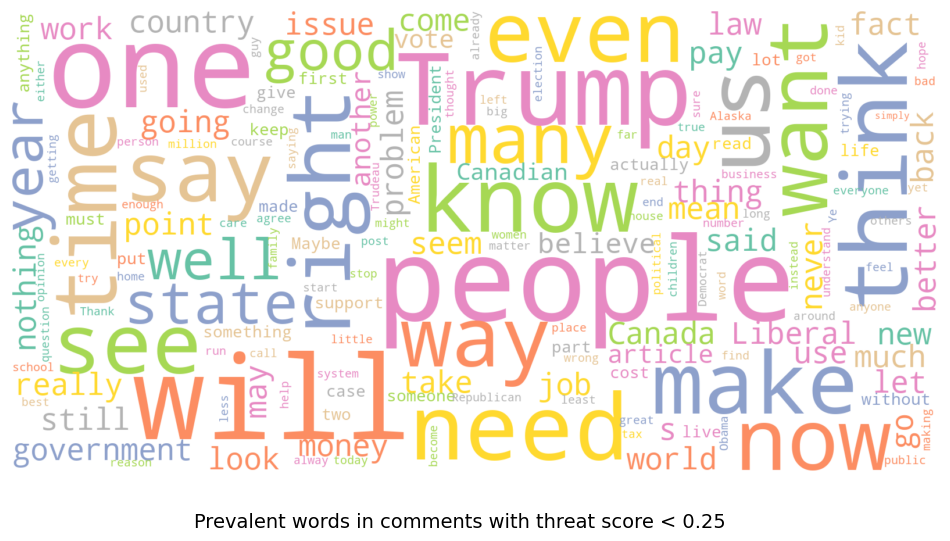

In [30]:
show_wordcloud(train.loc[train['threat'] < 0.25].sample(20000)['comment_text'], 
               title = 'Prevalent words in comments with threat score < 0.25')

/opt/conda/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


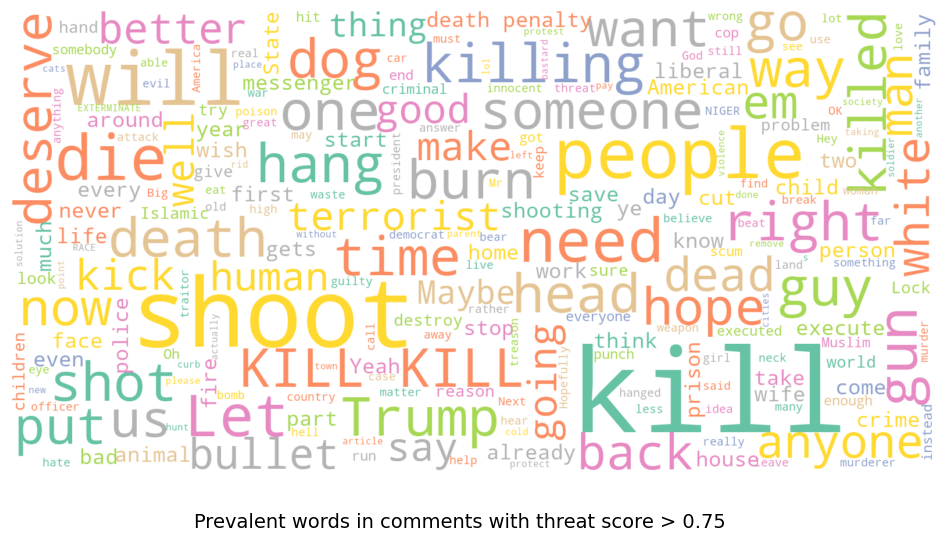

In [31]:
show_wordcloud(train.loc[train['threat'] > 0.75]['comment_text'], 
               title = 'Prevalent words in comments with threat score > 0.75')

Let's show the wordcloud of frequent words used in comments with obscene **score < 0.25** and obscene **score > 0.75**.

/opt/conda/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


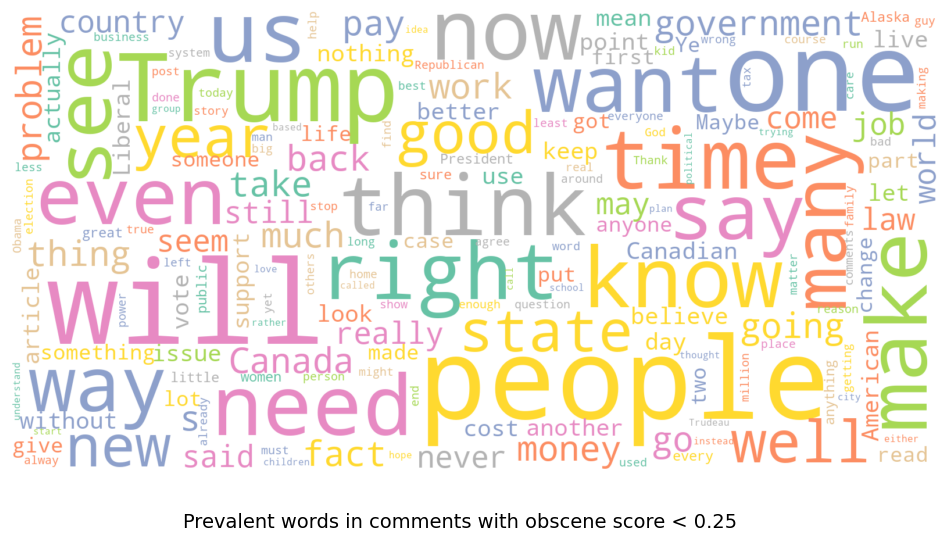

In [32]:
show_wordcloud(train.loc[train['obscene']< 0.25].sample(20000)['comment_text'], 
               title = 'Prevalent words in comments with obscene score < 0.25')

/opt/conda/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


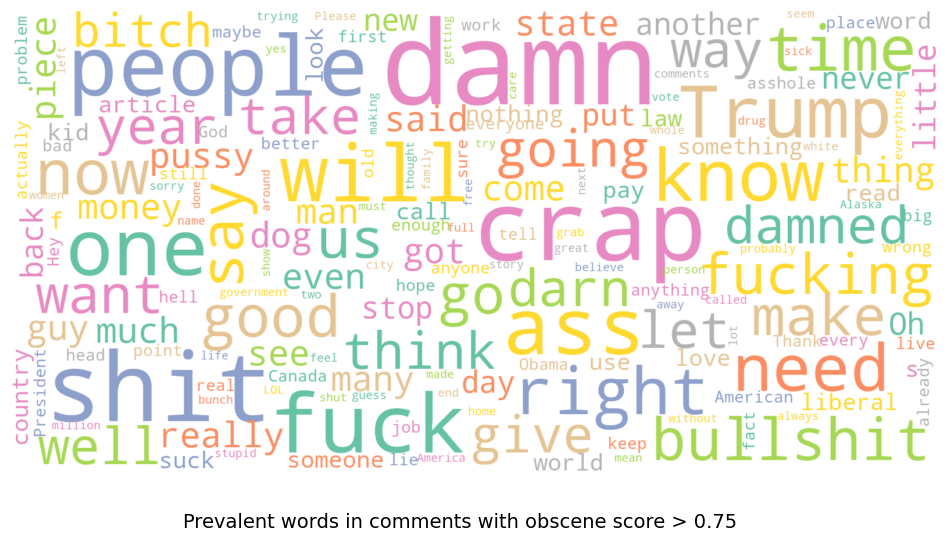

In [33]:
show_wordcloud(train.loc[train['obscene'] > 0.75]['comment_text'], 
               title = 'Prevalent words in comments with obscene score > 0.75')

Let's show now the prevalent words in comments with target (toxicity)  score under **0.25** and over **0.75**.

/opt/conda/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


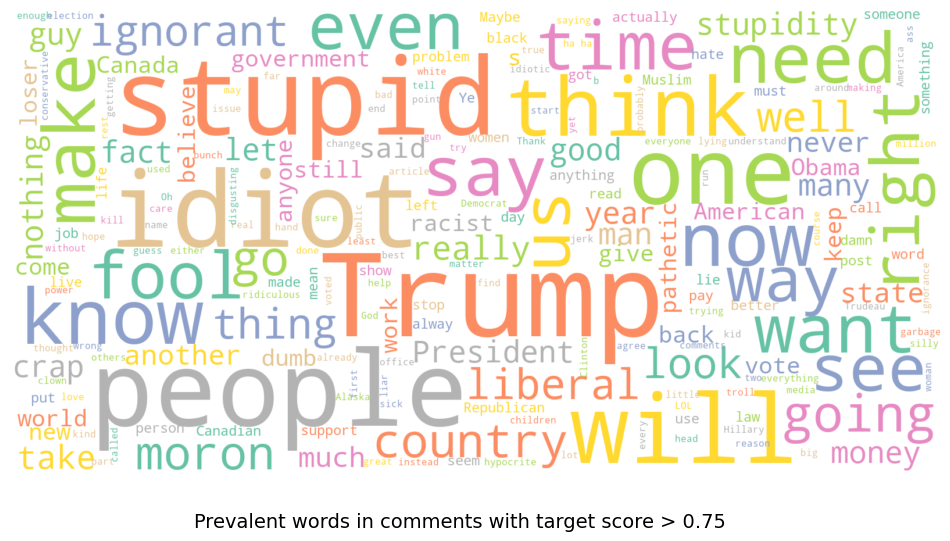

In [34]:
show_wordcloud(train.loc[train['target'] > 0.75]['comment_text'], 
               title = 'Prevalent words in comments with target score > 0.75')

/opt/conda/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


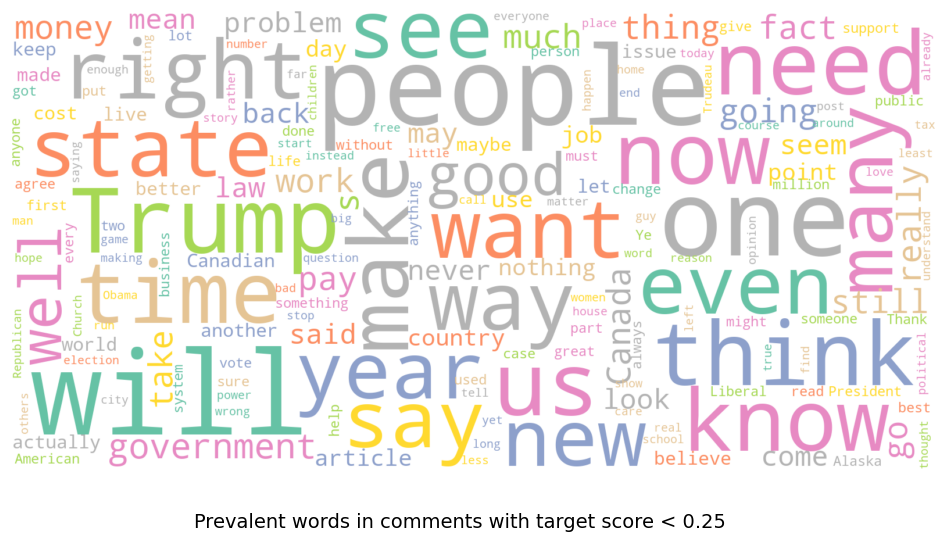

In [35]:
show_wordcloud(train.loc[train['target'] < 0.25].sample(20000)['comment_text'], 
               title = 'Prevalent words in comments with target score < 0.25')

---

<div style="float: right;">
        <a href="#0" class="button btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="Go to Top">Go to Top</a>
</div>

## <a id='35'>Comments data topic modelling</a>



### Train data

Let's perform topic modelling on a subset of the comments from train data.

In [36]:
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 2:
            result.append(token)
    return result

Let's verify the processor for one comment.

In [37]:
comment_sample = train['comment_text'][:1].values[0]
print('Original comment: {}'.format(comment_sample))
print('Tokenized comment: {}'.format(preprocess(comment_sample)))

Original comment: This is so cool. It's like, 'would you want your mother to read this??' Really great idea, well done!
Tokenized comment: ['cool', 'like', 'want', 'mother', 'read', 'great', 'idea']


Now we will apply preprocess on a sample of 20000 comments.

In [38]:
train_subsample = train.sample(20000)

In [39]:
%%time
preprocessed_comments = train_subsample['comment_text'].map(preprocess)

CPU times: user 3.45 s, sys: 1.86 ms, total: 3.45 s
Wall time: 3.46 s


Let's show few documents preprocessed.

In [40]:
print(preprocessed_comments.values[0:3])

[list(['tax', 'cuts', 'alway', 'paid', 'look', 'reagan', 'tax', 'rev', 'doubled', 'time', 'took', 'office', 'till', 'left', 'kennedy', 'thing', 'doubled', 'tax', 'rev', 'cutting', 'taxes', 'district', 'columbia', 'finally', 'cut', 'taxes', 'huge', 'surplus', 'additional', 'revenue', 'brought', 'works', 'creates', 'jobs', 'pays'])
 list(['old', 'arguments', 'shipping', 'manufacturing', 'downsizing', 'years', 'guarantees', 'long', 'term', 'commitments', 'economic', 'story', 'durham', 'region', 'fading', 'quickly', 'supporting', 'businesses', 'vacating', 'unemployment', 'rising', 'building', 'airport', 'won', 'replace', 'time', 'employees', 'length', 'time', 'airport', 'pretty', 'far', 'downtown', 'frankly', 'middle', 'comes', 'transportation', 'support', 'people', 'flying', 'markham', 'scarborough', 'arguments', 'major', 'cities', 'secondary', 'airports', 'like', 'new', 'york', 'paris', 'london', 'seriously', 'people', 'head', 'shake', 'counting', 'cities', 'thousands', 'flights', 'toron

Let's create now a dictionary. We set also some filters.

In [41]:
%%time
dictionary = gensim.corpora.Dictionary(preprocessed_comments)
dictionary.filter_extremes(no_below=10, no_above=0.5, keep_n=75000)

CPU times: user 940 ms, sys: 994 µs, total: 941 ms
Wall time: 941 ms


Let's generate a bag-of-words from the dictioanry and the corpus of comments (documents). 
Then, we generate a corpus and apply TF-IDF.

In [42]:
%%time
bow_corpus = [dictionary.doc2bow(doc) for doc in preprocessed_comments]
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

CPU times: user 570 ms, sys: 68 µs, total: 570 ms
Wall time: 570 ms


Let's now run LDA (Latent Dirichelet Allocation algorithm) with the result of TF-IDF applied to the bag-of-words corpus to generate 20 topics.

In [43]:
%%time
lda_model = gensim.models.LdaMulticore(corpus_tfidf, num_topics=20,
                                    id2word=dictionary, passes=2, workers=2)

CPU times: user 13.1 s, sys: 280 ms, total: 13.4 s
Wall time: 13.4 s


Let's represent the first 10 topics, each with 5 words.

In [44]:
topics = lda_model.print_topics(num_words=5)
for i, topic in enumerate(topics[:10]):
    print("Train topic {}: {}".format(i, topic))

Train topic 0: (0, '0.006*"tax" + 0.006*"yes" + 0.005*"income" + 0.004*"agree" + 0.003*"pay"')
Train topic 1: (1, '0.008*"good" + 0.005*"mean" + 0.004*"trump" + 0.004*"like" + 0.004*"right"')
Train topic 2: (2, '0.004*"think" + 0.004*"loser" + 0.004*"trump" + 0.004*"job" + 0.004*"point"')
Train topic 3: (3, '0.004*"vote" + 0.004*"quebec" + 0.004*"born" + 0.004*"book" + 0.003*"obama"')
Train topic 4: (4, '0.004*"like" + 0.004*"trump" + 0.004*"people" + 0.003*"know" + 0.003*"president"')
Train topic 5: (5, '0.003*"people" + 0.003*"good" + 0.003*"like" + 0.003*"black" + 0.003*"going"')
Train topic 6: (6, '0.005*"like" + 0.004*"people" + 0.004*"pay" + 0.004*"money" + 0.003*"health"')
Train topic 7: (7, '0.005*"trump" + 0.004*"people" + 0.003*"wrong" + 0.003*"like" + 0.002*"cool"')
Train topic 8: (8, '0.005*"know" + 0.004*"thanks" + 0.004*"year" + 0.004*"game" + 0.003*"people"')
Train topic 9: (9, '0.004*"people" + 0.004*"trump" + 0.003*"like" + 0.003*"time" + 0.003*"country"')


Let's use the LDA model to predict the type of topic for one document. 
We select one specific document (with index 5).

In [45]:
bd5 = bow_corpus[5]
for i in range(len(bd5)):
    print("Word {} (\"{}\") appears {} time.".format(bd5[i][0], dictionary[bd5[i][0]],bd5[i][1]))

Word 103 ("churchill") appears 1 time.
Word 104 ("donnie") appears 1 time.
Word 105 ("eat") appears 1 time.
Word 106 ("hope") appears 1 time.
Word 107 ("hoping") appears 1 time.
Word 108 ("know") appears 1 time.
Word 109 ("meant") appears 1 time.
Word 110 ("relationship") appears 1 time.
Word 111 ("sarcasm") appears 1 time.
Word 112 ("share") appears 1 time.
Word 113 ("special") appears 1 time.
Word 114 ("sure") appears 1 time.


In [46]:
for index, score in sorted(lda_model[bd5], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 5)))


Score: 0.8154633641242981	 
Topic: 0.004*"trump" + 0.004*"people" + 0.003*"read" + 0.003*"nice" + 0.003*"like"

Score: 0.11526887118816376	 
Topic: 0.004*"vote" + 0.004*"quebec" + 0.004*"born" + 0.004*"book" + 0.003*"obama"


We extracted the topics using LDA.
Let's represent the topics using the `pyLDAvis` tool.

In [47]:
vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dictionary)

We save the pyLDAvis graph as a html page.

In [48]:
pyLDAvis.save_html(vis, "LDAVis_train.html")

To access this page, select **Output** from the side menu of this Notebook.  
Select Press **Download** button next to the **LDAVis_train.html** item to display the widget.

To display this graph widget in the Notebook you will need to uncomment the next cell.

In [49]:
#vis

Let's check the most important topics per each comment.

In [50]:
def topic_sentences(ldamodel=lda_model, corpus=bow_corpus, \
                        texts=preprocessed_comments):
    # initialization
    sent_topics_df = pd.DataFrame()

    # get main topic in each comment
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # get the dominanttopic, % contribution and keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4),\
                                                                topic_keywords]), ignore_index=True)
            else:
                break
    text = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, text], axis=1)
    return(sent_topics_df)

In [51]:
topic_sents_keywords = topic_sentences(ldamodel=lda_model, corpus=bow_corpus, \
                                                  texts=preprocessed_comments)
dominant_topic =topic_sents_keywords.reset_index()
dominant_topic.columns = ['Comment', 'Dominant Topic', 'Topic Percent Contribution', 'Keywords','Text']
dominant_topic.head(5)

Comment  Dominant Topic  Topic Percent Contribution  \
0        0             0.0                      0.5019   
1        1            11.0                      0.2450   
2        2             5.0                      0.6832   
3        3            18.0                      0.7624   
4        4             7.0                      0.4747   

                                            Keywords Text  
0  tax, yes, income, agree, pay, people, think, l...  NaN  
1  said, great, people, trump, stupid, time, stor...  NaN  
2  people, good, like, black, going, time, riddan...  NaN  
3  trump, people, read, nice, like, let, governme...  NaN  
4  trump, people, wrong, like, cool, time, need, ...  NaN

### Test data

Let's repeat the same procedure for topic modelling but for test data now.

In [52]:
test_sample = test.sample(20000)

In [53]:
%%time
preprocessed_comments = test_sample['comment_text'].map(preprocess)
dictionary = gensim.corpora.Dictionary(preprocessed_comments)
dictionary.filter_extremes(no_below=10, no_above=0.5, keep_n=75000)
bow_corpus = [dictionary.doc2bow(doc) for doc in preprocessed_comments]
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

CPU times: user 4.36 s, sys: 29 ms, total: 4.38 s
Wall time: 4.39 s


In [54]:
%%time
lda_model = gensim.models.LdaMulticore(corpus_tfidf, num_topics=20,
                                    id2word=dictionary, passes=2, workers=2)

CPU times: user 13.4 s, sys: 269 ms, total: 13.7 s
Wall time: 13.7 s


Let's print the top 10 topics, each with 5 words.

In [55]:
topics = lda_model.print_topics(num_words=5)
for i, topic in enumerate(topics[:10]):
    print("Test topic {}: {}".format(i, topic))

Test topic 0: (0, '0.005*"comment" + 0.005*"got" + 0.004*"trump" + 0.004*"like" + 0.004*"good"')
Test topic 1: (1, '0.005*"good" + 0.004*"maybe" + 0.004*"trump" + 0.004*"people" + 0.004*"like"')
Test topic 2: (2, '0.009*"said" + 0.005*"exactly" + 0.004*"trump" + 0.003*"like" + 0.003*"vote"')
Test topic 3: (3, '0.006*"kids" + 0.005*"agree" + 0.004*"english" + 0.004*"like" + 0.003*"hear"')
Test topic 4: (4, '0.004*"people" + 0.004*"pope" + 0.003*"church" + 0.003*"right" + 0.003*"like"')
Test topic 5: (5, '0.004*"canada" + 0.004*"china" + 0.004*"talking" + 0.003*"people" + 0.003*"world"')
Test topic 6: (6, '0.004*"trump" + 0.004*"people" + 0.003*"man" + 0.003*"black" + 0.003*"like"')
Test topic 7: (7, '0.007*"com" + 0.007*"www" + 0.006*"https" + 0.005*"wrong" + 0.004*"watch"')
Test topic 8: (8, '0.005*"funny" + 0.004*"like" + 0.004*"people" + 0.003*"trump" + 0.003*"think"')
Test topic 9: (9, '0.006*"good" + 0.005*"trump" + 0.004*"fake" + 0.004*"headline" + 0.004*"story"')


We save the pyLDAvis graph as a html page. 

In [56]:
vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dictionary)
pyLDAvis.save_html(vis, "LDAVis_test.html")

To access this page, select **Output** from the side menu of this Notebook.  
Select Press **Download** button next to the **LDAVis_test.html**  item to display the widget.

To display this graph widget in the Notebook you will need to uncomment the next cell.

In [57]:
#vis

---

<div style="float: right;">
        <a href="#0" class="button btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="Go to Top">Go to Top</a>
</div>

## <a id='36'>Comments name entity recognition (NER)</a>  

In [58]:
nlp = spacy.load('en_core_web_sm')

Let's create a subset of documents that are short and also contains political names, like Trump or Obama.

In [59]:
selected_text = train.loc[train['comment_text'].str.contains("Trump") | train['comment_text'].str.contains("Obama")] 

In [60]:
selected_text["len"] = selected_text['comment_text'].apply(lambda x: len(x))

In [61]:
selected_text = selected_text.loc[selected_text.len < 100]
selected_text.shape

(21778, 45)

In [62]:
sentence = selected_text['comment_text'].values[0]
doc = nlp(sentence)
for ent in doc.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

Bernie 32 38 PERSON
Trump 71 76 ORG


In [63]:
displacy.render(doc, style="ent",jupyter=True)

/opt/conda/lib/python3.10/site-packages/spacy/displacy/__init__.py:71: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [64]:
spacy.explain("ORG")

'Companies, agencies, institutions, etc.'

In [65]:
spacy.explain("PERSON")

'People, including fictional'

In [66]:
for sentence in selected_text["comment_text"].head(5):
    print("\n")
    doc = nlp(sentence)
    for ent in doc.ents:
        print(ent.text, ent.start_char, ent.end_char, ent.label_)
    displacy.render(doc, style="ent",jupyter=True)



Bernie 32 38 PERSON
Trump 71 76 ORG


/opt/conda/lib/python3.10/site-packages/spacy/displacy/__init__.py:71: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


/opt/conda/lib/python3.10/site-packages/spacy/displacy/__init__.py:71: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML




Trump 12 17 PERSON
Ted 28 31 PERSON


/opt/conda/lib/python3.10/site-packages/spacy/displacy/__init__.py:71: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML




Obama 38 43 PERSON


/opt/conda/lib/python3.10/site-packages/spacy/displacy/__init__.py:71: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML




republicans 25 36 NORP
Obama 70 75 LOC


/opt/conda/lib/python3.10/site-packages/spacy/displacy/__init__.py:71: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


---

<div style="float: right;">
        <a href="#0" class="button btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="Go to Top">Go to Top</a>
</div>

## <a id='37'>Comments part of speech tagging</a>  

Let's check now part of speech tagging using nltk.

In [67]:
for sentence in selected_text["comment_text"].head(5):
    print("\n")
    tokens = twt().tokenize(sentence)
    tags = nltk.pos_tag(tokens, tagset = "universal")
    for tag in tags:
        print(tag, end=" ")



('Is', 'VERB') ('there', 'DET') ('evidence', 'NOUN') ('that', 'ADP') ('it', 'PRON') ('was', 'VERB') ('a', 'DET') ('Bernie', 'NOUN') ('supporter', 'NOUN') ('?', '.') ('Last', 'ADJ') ('time', 'NOUN') ('I', 'PRON') ('checked', 'VERB') (',', '.') ('Trump', 'NOUN') ('supporters', 'NOUN') ('poop', 'VERB') ('too', 'ADV') ('.', '.') 

('Go', 'NOUN') ('Trump', 'NOUN') (',', '.') ('Go', 'NOUN') ('!', '.') ('!', '.') 

('I', 'PRON') ('agree.', 'VERB') ('Go', 'NOUN') ('Trump', 'NOUN') (',', '.') ('and', 'CONJ') ('take', 'VERB') ('Ted', 'NOUN') ('with', 'ADP') ('you', 'PRON') ('.', '.') 

('The', 'DET') ('discourse', 'NOUN') ('may', 'VERB') ('have', 'VERB') ('been', 'VERB') ('civil', 'ADJ') ('but', 'CONJ') ('Obama', 'NOUN') ("'s", 'PRT') ('presidency', 'NOUN') ('has', 'VERB') ('been', 'VERB') ('obscene', 'VERB') ('.', '.') 

('Exactly.', 'NOUN') ('And', 'CONJ') ('already', 'ADV') ('the', 'DET') ('republicans', 'NOUN') ('are', 'VERB') ("'digging", 'VERB') ('in', 'ADP') ("'", '.') ('and', 'CONJ') (

Let's also visualize the same, now using spacy.

In [68]:
for sentence in selected_text["comment_text"].head(5):
    print("\n")
    doc = nlp(sentence)
    for token in doc:
        print(token.text, token.pos_, token.ent_type_, end=" | ")



Is AUX  | there PRON  | evidence NOUN  | that SCONJ  | it PRON  | was AUX  | a DET  | Bernie PROPN PERSON | supporter NOUN  | ? PUNCT  | Last ADJ  | time NOUN  | I PRON  | checked VERB  | , PUNCT  | Trump NOUN ORG | supporters NOUN  | poop VERB  | too ADV  | . PUNCT  | 

Go VERB  | Trump PROPN  | , PUNCT  | Go PROPN  | ! PUNCT  | ! PUNCT  | 

I PRON  | agree VERB  | . PUNCT  | Go VERB  | Trump PROPN PERSON | , PUNCT  | and CCONJ  | take VERB  | Ted PROPN PERSON | with ADP  | you PRON  | . PUNCT  | 

The DET  | discourse NOUN  | may AUX  | have AUX  | been AUX  | civil ADJ  | but CCONJ  | Obama PROPN PERSON | 's PART  | presidency NOUN  | has AUX  | been AUX  | obscene ADJ  | . PUNCT  | 

Exactly ADV  | . PUNCT  | And CCONJ  | already ADV  | the DET  | republicans PROPN NORP | are AUX  | ' PUNCT  | digging VERB  | in ADP  | ' PUNCT  | and CCONJ  | threatening VERB  | Obama PROPN LOC | . PUNCT  | 

In [69]:
for sentence in selected_text["comment_text"].head(5):
    print("\n")
    doc = nlp(sentence)
    displacy.render(doc, style="dep",jupyter=True)

/opt/conda/lib/python3.10/site-packages/spacy/displacy/__init__.py:71: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


/opt/conda/lib/python3.10/site-packages/spacy/displacy/__init__.py:71: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


/opt/conda/lib/python3.10/site-packages/spacy/displacy/__init__.py:71: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


/opt/conda/lib/python3.10/site-packages/spacy/displacy/__init__.py:71: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


/opt/conda/lib/python3.10/site-packages/spacy/displacy/__init__.py:71: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


We would like to use the code in [10] but we already observed that the part of speech are incorectly detected in several cases. So, we will modify the code to use span from nltk but we will get the tags from spacy, with the same method used above. The modified code from [10] which fix the bug is given below.

In [70]:
import re
def visualize_pos(sentence):
    colors = {"PRON": "blueviolet",
              "VERB": "lightpink",
              "NOUN": "turquoise",
              "PROPN": "lightgreen",
              "ADJ" : "lime",
              "ADP" : "khaki",
              "ADV" : "orange",
              "AUX" : "gold",
              "CONJ" : "cornflowerblue",
              "CCONJ" : "magenta",
              "SCONJ" : "lightmagenta",
              "DET" : "forestgreen",
              "NUM" : "salmon",
              "PRT" : "yellow",
              "PUNCT": "lightgrey"}
        
    pos_tags = ["PRON", "VERB", "NOUN", "PROPN", "ADJ", "ADP",
                "ADV", "AUX", "CONJ", "CCONJ", "SCONJ",  "DET", "NUM", "PRT", "PUNCT"]
    
    # Fix for 
    sentence = sentence.replace(".", " .")
    sentence = sentence.replace("'", "")
    # Replace nltk tokenizer with spacy tokenizer and POS tagging
    doc = nlp(sentence)
    tags = []
    for token in doc:
        tags.append((token.text, token.pos_))
    
    # Get start and end index (span) for each token
    span_generator = twt().span_tokenize(sentence)
    spans = [span for span in span_generator]

    # Create dictionary with start index, end index, 
    # pos_tag for each token
    ents = []
    for tag, span in zip(tags, spans):
        if tag[1] in pos_tags:
            ents.append({"start" : span[0], 
                         "end" : span[1], 
                         "label" : tag[1] })

    doc = {"text" : sentence, "ents" : ents}


    
    options = {"ents" : pos_tags, "colors" : colors}
    
    displacy.render(doc, 
                    style = "ent", 
                    options = options, 
                    manual = True,
                   )

In [71]:
for sentence in selected_text["comment_text"].head(5):
    print("\n")
    visualize_pos(sentence)

/opt/conda/lib/python3.10/site-packages/spacy/displacy/__init__.py:71: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


/opt/conda/lib/python3.10/site-packages/spacy/displacy/__init__.py:71: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


/opt/conda/lib/python3.10/site-packages/spacy/displacy/__init__.py:71: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


/opt/conda/lib/python3.10/site-packages/spacy/displacy/__init__.py:71: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


/opt/conda/lib/python3.10/site-packages/spacy/displacy/__init__.py:71: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


---

<div style="float: right;">
        <a href="#0" class="button btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="Go to Top">Go to Top</a>
</div>

# <a id='4'>Prepare the model</a>  

In preparation for the model using Deep Learning, there are two rules formulated by @christofhenkel [8][9]:
* Don't use standard preprocessing steps like stemming or stopword removal when you have pre-trained embeddings  
* Get your vocabulary as close to the embeddings as possible   



## <a id='41'>Build vocabulary</a>  

We start with building the vocabulary. First we set few constants, as following:  
* **EMBED_SIZE** - embedding size - the size of word vector - should match the embedding source (GloVe);  
* **MAX_FEATURES** - Maximum number of features - the number of unique words to use or number of rows in the embedding vector;  
* **MAXLEN** - The maximum length of comments text

In [72]:
EMBED_SIZE = 300 # size of word vector; this should be set to 300 to match the embedding source
MAX_FEATURES = 100000 # how many unique words to use (i.e num rows in embedding vector)
MAXLEN = 220 # max length of comments text

The following function is from [8][9]. It builds the vocabulary by browsing all comments, splits in sentences, sentences in words. An accumulator is created, with the value associated to each word equal with the accumulated value.

In [73]:
def build_vocabulary(texts):
    """
    Build the vocabulary from the corpus
    Credits to: [9] [10]
    Args:
        texts: list of list of words
    Returns:
        dictionary of words and their count
    """
    sentences = texts.apply(lambda x: x.split()).values
    vocab = {}
    for sentence in tqdm(sentences):
        for word in sentence:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab

We concatenate train and test and build an unique vocabulary with both datasets.

In [74]:
# populate the vocabulary
df = pd.concat([train ,test], sort=False)
vocabulary = build_vocabulary(df['comment_text'])

100%|██████████| 1902194/1902194 [00:29<00:00, 65155.53it/s]


Let's check the first 10 elements of the vocabulary.

In [75]:
# display the first 10 elements and their count
print({k: vocabulary[k] for k in list(vocabulary)[:10]})

{'This': 127947, 'is': 1534062, 'so': 222745, 'cool.': 503, "It's": 86489, 'like,': 2430, "'would": 13, 'you': 773969, 'want': 101084, 'your': 309288}


## <a id='42'>Embedding index and embedding matrix</a>

Let's build the embedding index (this is a dictionary with keys the embeddings and the values are arrays of their embedding representations) and embedding matrix (a matrix representation of the embeddings).  


In [76]:
def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype='float32')

def load_embeddings(file_path):
    """
    Load the embeddings
    Credits to: [9] [10]
    Args:
        file_path: path to the embeddings file
    Returns:
        embedding index
    """
    with open(file_path) as f:
        return dict(get_coefs(*line.strip().split(' ')) for line in f)

In [77]:
%%time
GLOVE_PATH = '../input/glove840b300dtxt/'
print("Extracting GloVe embedding started")
embed_glove = load_embeddings(os.path.join(GLOVE_PATH,'glove.840B.300d.txt'))
print("Embedding completed")

Extracting GloVe embedding started
Embedding completed
CPU times: user 3min 5s, sys: 6.33 s, total: 3min 12s
Wall time: 3min 29s


Let's check the size of embeeding structure loaded.

In [78]:
len(embed_glove)

2196008

Let's now create the embeeding matrix using the word index and the embeeding index created. We are using the MAX_FEATURES to limit the number of features thus the size of embeeding matrix. 

In [79]:
def embedding_matrix(word_index, embeddings_index):
    '''
    Create the embedding matrix
    credits to: [9] [10] 
    Args:
        word_index: word index (from vocabulary)
        embedding_index: embedding index (from embeddings file)
    Returns:
        embedding matrix
    '''
    all_embs = np.stack(embeddings_index.values())
    emb_mean, emb_std = all_embs.mean(), all_embs.std()
    EMBED_SIZE = all_embs.shape[1]
    nb_words = min(MAX_FEATURES, len(word_index))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, EMBED_SIZE))
    for word, i in tqdm(word_index.items()):
        if i >= MAX_FEATURES:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

## <a id='43'>Check coverage</a>

With the following function, we check coverage of embeddings for the vocabulary created from the train and test dataset. We will sue this function repeatedly after each pre-processing operation.

In [80]:
def check_coverage(vocab, embeddings_index):
    '''
    Check the vocabulary coverage by the embedding terms
    credits to: [9] [10]
    Args:
        vocab: vocabulary
        embedding_index: embedding index (from embeddings file)
    Returns:
        list of unknown words; also prints the vocabulary coverage of embeddings and 
        the % of comments text covered by the embeddings
    '''
    known_words = {}
    unknown_words = {}
    nb_known_words = 0
    nb_unknown_words = 0
    for word in tqdm(vocab.keys()):
        try:
            known_words[word] = embeddings_index[word]
            nb_known_words += vocab[word]
        except:
            unknown_words[word] = vocab[word]
            nb_unknown_words += vocab[word]
            pass
    print('Found embeddings for {:.3%} of vocabulary'.format(len(known_words)/len(vocab)))
    print('Found embeddings for {:.3%} of all text'.format(nb_known_words/(nb_known_words + nb_unknown_words)))
    unknown_words = sorted(unknown_words.items(), key=operator.itemgetter(1))[::-1]
    return unknown_words

Let's check the initial coverage of vocabulary.

In [81]:
print("Verify the intial vocabulary coverage")
oov_glove = check_coverage(vocabulary, embed_glove)

Verify the intial vocabulary coverage


100%|██████████| 1729911/1729911 [00:03<00:00, 564909.71it/s]


Found embeddings for 15.584% of vocabulary
Found embeddings for 89.634% of all text


Embedding only cover ~15% of the vocabulary and this accounts for 89.6% from the entire comments texts.  
Let's check what kind of words are missing from the embeddings.

In [82]:
oov_glove[:10]

[("isn't", 42161),
 ("That's", 39552),
 ("won't", 30975),
 ("he's", 25704),
 ("Trump's", 24736),
 ("aren't", 21626),
 ("wouldn't", 20569),
 ('Yes,', 20092),
 ('that,', 19237),
 ("wasn't", 19107)]

Most of the missing words are punctuation and upper case words. Let's remove punctuation and apply lowerisation (i.e. turn all words to lowercase).

## <a id='44'>Transform to lowercase</a>

In [83]:
def add_lower(embedding, vocab):
    '''
    Add lower case words
    credits to: [9] [10]
    Args:
        embedding: embedding matrix
        vocab: vocabulary
    Returns:
        None
        modify the embeddings to include the lower case from vocabulary
    '''
    count = 0
    for word in tqdm(vocab):
        if word in embedding and word.lower() not in embedding:  
            embedding[word.lower()] = embedding[word]
            count += 1
    print(f"Added {count} words to embedding")

In [84]:
train['comment_text'] = train['comment_text'].apply(lambda x: x.lower())
test['comment_text'] = test['comment_text'].apply(lambda x: x.lower())

In [85]:
print("Check coverage for vocabulary with lower case")
oov_glove = check_coverage(vocabulary, embed_glove)
add_lower(embed_glove, vocabulary) # operates on the same vocabulary
oov_glove = check_coverage(vocabulary, embed_glove)

Check coverage for vocabulary with lower case


100%|██████████| 1729911/1729911 [00:04<00:00, 405285.92it/s]


Found embeddings for 15.584% of vocabulary
Found embeddings for 89.634% of all text


100%|██████████| 1729911/1729911 [00:01<00:00, 1256799.09it/s]


Added 25360 words to embedding


100%|██████████| 1729911/1729911 [00:03<00:00, 527878.71it/s]


Found embeddings for 15.702% of vocabulary
Found embeddings for 89.662% of all text


Let's check again the words not included in embeddings.

In [86]:
oov_glove[:10]

[("isn't", 42161),
 ("That's", 39552),
 ("won't", 30975),
 ("he's", 25704),
 ("Trump's", 24736),
 ("aren't", 21626),
 ("wouldn't", 20569),
 ('Yes,', 20092),
 ('that,', 19237),
 ("wasn't", 19107)]

We can observe that most of the remaining include contractions and words with punctuation. We continue with removing contractions.

## <a id='45'>Remove contractions</a> 

Contractions are modified forms of words and expressions. We will map, using the following dictionary, the contracted forms on words existent in embeddings.



In [87]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have", 'colour': 'color', 'centre': 'center', 'favourite': 'favorite', 'travelling': 'traveling', 'counselling': 'counseling', 'theatre': 'theater', 'cancelled': 'canceled', 'labour': 'labor', 'organisation': 'organization', 'wwii': 'world war 2', 'citicise': 'criticize', 'youtu ': 'youtube ', 'Qoura': 'Quora', 'sallary': 'salary', 'Whta': 'What', 'narcisist': 'narcissist', 'howdo': 'how do', 'whatare': 'what are', 'howcan': 'how can', 'howmuch': 'how much', 'howmany': 'how many', 'whydo': 'why do', 'doI': 'do I', 'theBest': 'the best', 'howdoes': 'how does', 'mastrubation': 'masturbation', 'mastrubate': 'masturbate', "mastrubating": 'masturbating', 'pennis': 'penis', 'Etherium': 'Ethereum', 'narcissit': 'narcissist', 'bigdata': 'big data', '2k17': '2017', '2k18': '2018', 'qouta': 'quota', 'exboyfriend': 'ex boyfriend', 'airhostess': 'air hostess', "whst": 'what', 'watsapp': 'whatsapp', 'demonitisation': 'demonetization', 'demonitization': 'demonetization', 'demonetisation': 'demonetization'}
len(contraction_mapping)

162

In [88]:
def known_contractions(embed):
    '''
    Add know contractions
    credits to: [9] [10]
    Args:
        embed: embedding matrix
    Returns:
        known contractions (from embeddings)
    '''
    known = []
    for contract in tqdm(contraction_mapping):
        if contract in embed:
            known.append(contract)
    return known

In [89]:
print("Known contractions in GloVe embeddings:")
print(known_contractions(embed_glove))

Known contractions in GloVe embeddings:


100%|██████████| 162/162 [00:00<00:00, 555582.38it/s]

["can't", "'cause", "didn't", "doesn't", "don't", "I'd", "I'll", "I'm", "I've", "i'd", "i'll", "i'm", "i've", "it's", "ma'am", "o'clock", "that's", "you'll", "you're", 'colour', 'centre', 'favourite', 'travelling', 'counselling', 'theatre', 'cancelled', 'labour', 'organisation', 'wwii', 'sallary', 'Whta', 'narcisist', 'howdo', 'whatare', 'howcan', 'howmuch', 'howmany', 'doI', 'theBest', 'mastrubation', 'mastrubate', 'mastrubating', 'pennis', 'Etherium', 'bigdata', 'qouta', 'exboyfriend', 'airhostess', 'whst', 'watsapp']


In [90]:
def clean_contractions(text, mapping):
    '''
    Clean the contractions
    
    credits to: [9] [10]
    Args:
        text: current text
        mapping: contraction mappings
    Returns: modify the comments to use the base form from contraction mapping
    '''
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        text = text.replace(s, "'")
    text = ' '.join([mapping[t] if t in mapping else t for t in text.split(" ")])
    return text

In [91]:
train['comment_text'] = train['comment_text'].apply(lambda x: clean_contractions(x, contraction_mapping))
test['comment_text'] = test['comment_text'].apply(lambda x: clean_contractions(x, contraction_mapping))

We will build again the vocabulary and check again the coverage.

In [92]:
df = pd.concat([train ,test], sort=False)
vocab = build_vocabulary(df['comment_text'])
print("Check embeddings after applying contraction mapping")
oov_glove = check_coverage(vocab, embed_glove)

100%|██████████| 1902194/1902194 [00:30<00:00, 63401.54it/s]


Check embeddings after applying contraction mapping


100%|██████████| 1505789/1505789 [00:02<00:00, 577403.79it/s]


Found embeddings for 13.570% of vocabulary
Found embeddings for 90.419% of all text


In [93]:
oov_glove[:10]

[('yes,', 29444),
 ("trump's", 28554),
 ('"the', 26420),
 ('so,', 21352),
 ('well,', 21219),
 ('however,', 20762),
 ('that,', 20028),
 ('(and', 18247),
 ('no,', 17866),
 ('trump.', 17644)]

It seems that, with lowercase transformation and contraction treatment, the improvement in termns of coverage is not significant. Punctuation, which we didn't treated yet, seems to be really important.

## <a id='46'>Remove punctuation</a>  

We remove as well punctuation.

In [94]:
punct_mapping = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'
punct_mapping += '©^®` <→°€™› ♥←×§″′Â█½à…“★”–●â►−¢²¬░¶↑±¿▾═¦║―¥▓—‹─▒：¼⊕▼▪†■’▀¨▄♫☆é¯♦¤▲è¸¾Ã⋅‘∞∙）↓、│（»，♪╩╚³・╦╣╔╗▬❤ïØ¹≤‡√'

def unknown_punct(embed, punct):
    '''
    Find the unknown punctuation
    credits to: [9] [10] 
    Args:
        embed: embedding matrix
        punct: punctuation
    Returns:
        unknown punctuation
    '''
    unknown = ''
    for p in punct:
        if p not in embed:
            unknown += p
            unknown += ' '
    return unknown

In [95]:
print("Find unknown punctuation:")
print(unknown_punct(embed_glove, punct_mapping))

Find unknown punctuation:
₹     


In [96]:
puncts = {"‘": "'", "´": "'", "°": "", "€": "euro", "—": "-", "–": "-", "’": "'", "_": "-", "`": "'", '“': '"', '”': '"', '“': '"', "£": "pound",
          '∞': 'infinity', 'θ': 'theta', '÷': '/', 'α': 'alpha', '•': '.', 'à': 'a', '−': '-', 'β': 'beta', '∅': '', '³': '3', 'π': 'pi', '…': ' '}


def clean_special_chars(text, punct, mapping):
    '''
    Clean special characters
    credits to: [9] [10]
    Args:
        text: current text
        punct: punctuation
        mapping: punctuation mapping
    Returns:
        cleaned text
    '''
    for p in mapping:
        text = text.replace(p, mapping[p])
    for p in punct:
        text = text.replace(p, f' {p} ') 
    return text

In [97]:
train['comment_text'] = train['comment_text'].apply(lambda x: clean_special_chars(x, punct_mapping, puncts))
test['comment_text'] = test['comment_text'].apply(lambda x: clean_special_chars(x, punct_mapping, puncts))

Let's rebuid the vocabulary after replacing the punctuation and check again the coverage.

In [98]:
%%time
df = pd.concat([train ,test], sort=False)
vocab = build_vocabulary(df['comment_text'])
print("Check coverage after punctuation replacement")
oov_glove = check_coverage(vocab, embed_glove)

100%|██████████| 1902194/1902194 [00:28<00:00, 66429.94it/s]


Check coverage after punctuation replacement


100%|██████████| 321054/321054 [00:00<00:00, 579349.17it/s]


Found embeddings for 54.600% of vocabulary
Found embeddings for 99.733% of all text
CPU times: user 53.4 s, sys: 809 ms, total: 54.3 s
Wall time: 54.2 s


In [99]:
oov_glove[:20]

[('brexit', 2028),
 ('theglobeandmail', 1431),
 ('drumpf', 1328),
 ('deplorables', 1253),
 ('trumpcare', 858),
 ('sb91', 832),
 ('theguardian', 781),
 ('klastri', 749),
 ('trumpism', 595),
 ('ᴀ', 532),
 ('ᴀɴᴅ', 519),
 ('auwe', 502),
 ('trumpsters', 411),
 ('trumpian', 407),
 ('wiliki', 395),
 ('2gtbpns', 381),
 ('saullie', 362),
 ('ᴛʜᴇ', 360),
 ('ʜᴏᴍᴇ', 345),
 ('ᴜᴘ', 344)]

There is a significant improvement by extracting punctuation. 99.7% from the text is covered by the embeddings and 57% of the vocabulary. Punctuation appears to be very important.


Let's also apply additional punctuation corrections.

In [100]:
more_puncts = {'▀': '.', '▄': '.', 'é': 'e', 'è': 'e', 'ï': 'i','✰': 'star', 'ᴀ': 'A',  'ᴀɴᴅ': 'and', '»': ' '}

In [101]:
train['comment_text'] = train['comment_text'].apply(lambda x: clean_special_chars(x, punct_mapping, more_puncts))
test['comment_text'] = test['comment_text'].apply(lambda x: clean_special_chars(x, punct_mapping, more_puncts))

In [102]:
%%time
df = pd.concat([train ,test], sort=False)
vocab = build_vocabulary(df['comment_text'])
print("Check coverage after additional punctuation replacement")
oov_glove = check_coverage(vocab, embed_glove)

100%|██████████| 1902194/1902194 [00:29<00:00, 63640.74it/s]


Check coverage after additional punctuation replacement


100%|██████████| 321047/321047 [00:00<00:00, 581023.12it/s]


Found embeddings for 54.599% of vocabulary
Found embeddings for 99.733% of all text
CPU times: user 1min 3s, sys: 1.65 s, total: 1min 5s
Wall time: 1min 5s


In [103]:
oov_glove[:20]

[('brexit', 2028),
 ('theglobeandmail', 1431),
 ('drumpf', 1328),
 ('deplorables', 1253),
 ('trumpcare', 858),
 ('sb91', 832),
 ('theguardian', 781),
 ('klastri', 749),
 ('trumpism', 595),
 ('Aɴᴅ', 519),
 ('auwe', 502),
 ('trumpsters', 411),
 ('trumpian', 407),
 ('wiliki', 395),
 ('2gtbpns', 381),
 ('saullie', 362),
 ('ᴛʜᴇ', 360),
 ('ʜᴏᴍᴇ', 345),
 ('ᴜᴘ', 344),
 ('ʙʏ', 343)]

## Extend embeddings

We can extend the embeddings by including additional word embeddings data. Let's load now, besides GloVe, also FastText from Facebook.

In [104]:
%%time
FASTTEXT_PATH = '/kaggle/input/fasttext-crawl-300d-2m'
print("Extracting FastText embedding started")
embed_fasttext = load_embeddings(os.path.join(FASTTEXT_PATH,'crawl-300d-2M.vec'))
print("Embedding FastText completed")

Extracting FastText embedding started
Embedding FastText completed
CPU times: user 2min 50s, sys: 3.79 s, total: 2min 54s
Wall time: 3min 2s


Let's concatenate the embedding index from embed_glove and embed_fasttext.

Let's check the length of the two dictionaries.

In [105]:
len(embed_fasttext), len(embed_glove)

(2000000, 2221368)

Let's merge the two dictionary.

In [106]:
embed_all = dict(embed_glove, **embed_fasttext)

Now we can check the result of merging the two embeddings dictionary (indexes).

In [107]:
len(embed_all)

2863385

We check now the result of suplementing the embeddings from the alternative source (FastText).

In [108]:
%%time
df = pd.concat([train ,test], sort=False)
vocab = build_vocabulary(df['comment_text'])
print("Check coverage after suplementing the embeddings")
oov_all = check_coverage(vocab, embed_all)

100%|██████████| 1902194/1902194 [00:28<00:00, 65836.62it/s]


Check coverage after suplementing the embeddings


100%|██████████| 321047/321047 [00:00<00:00, 491334.39it/s]


Found embeddings for 56.464% of vocabulary
Found embeddings for 99.754% of all text
CPU times: user 1min 6s, sys: 1.57 s, total: 1min 7s
Wall time: 1min 7s


In [109]:
oov_all[:20]

[('theglobeandmail', 1431),
 ('sb91', 832),
 ('klastri', 749),
 ('Aɴᴅ', 519),
 ('auwe', 502),
 ('trumpsters', 411),
 ('trumpian', 407),
 ('wiliki', 395),
 ('2gtbpns', 381),
 ('saullie', 362),
 ('ᴛʜᴇ', 360),
 ('ʜᴏᴍᴇ', 345),
 ('ᴜᴘ', 344),
 ('ʙʏ', 343),
 ('yᴏᴜ', 342),
 ('Aᴛ', 342),
 ('vinis', 331),
 ('rangermc', 323),
 ('sjws', 314),
 ('civilbeat', 313)]

## <a id='47'>Tokenize</a>

We apply tokenization for train and test. 

In [110]:
%%time
tokenizer = Tokenizer(num_words=MAX_FEATURES)
tokenizer.fit_on_texts(list(train))
train = tokenizer.texts_to_sequences(train)
test = tokenizer.texts_to_sequences(test)

CPU times: user 1.21 ms, sys: 0 ns, total: 1.21 ms
Wall time: 1.21 ms


# <a id='5'>Conclusions</a>  

We applied succesively several techniques to improve the vocabulary coverage with GloVe for the entire corpus of texts in `comment_text`, as following:
* transform to lowercase;  
* remove contractions;  
* remove punctuation;  


By just using these simple text transformation, we were able to found embeddings for 54.401% of vocabulary and for 99.718% of all text, from the orginial coverage, before these processings, of 15% of the vocabularyand 89.6% from all text.

Then, by extending the embeddings indexes with FastText, from Facebook, besides the initial GloVe, from Stanford, we obtained a coverage of 56% of vocabulary and 99.75% of all text.

# <a id='6'>References</a>  

[1] https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/  
[2] https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24  
[3] https://towardsdatascience.com/improving-the-interpretation-of-topic-models-87fd2ee3847d  
[4] https://www.aclweb.org/anthology/W14-3110   
[5] https://www.objectorientedsubject.net/2018/08/experiments-on-topic-modeling-pyldavis/  
[6] https://www.kaggle.com/errearanhas/topic-modelling-lda-on-elon-tweets  
[7] https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation  
[8]  https://towardsdatascience.com/visualizing-part-of-speech-tags-with-nltk-and-spacy-42056fcd777e
[9] https://www.kaggle.com/anebzt/quora-preprocessing-model  
[10] https://www.kaggle.com/christofhenkel/how-to-preprocessing-when-using-embeddings  



